### Formula 1 Modeling

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import fastf1 as ff1
from fastf1 import plotting
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer



circuits = pd.read_csv('circuits.csv')
constructor_results = pd.read_csv('constructor_results.csv')
constructor_standings = pd.read_csv('constructor_standings.csv')
constructors = pd.read_csv('constructors.csv')
driver_standings = pd.read_csv('driver_standings.csv')
drivers = pd.read_csv('drivers.csv')
lap_times = pd.read_csv('lap_times.csv')
pit_stops = pd.read_csv('pit_stops.csv')
qualifying = pd.read_csv('qualifying.csv')
races = pd.read_csv('races.csv')
results = pd.read_csv('results.csv')
seasons = pd.read_csv('seasons.csv')
sprint_results = pd.read_csv('sprint_results.csv')
status = pd.read_csv('status.csv')
weather_new = pd.read_csv('weather_f1.csv')
merged_data = pd.read_csv('10-04-2023-merged.csv')


C:\Users\Mixit\AppData\Local\Temp\ipykernel_30980\3192657732.py:30: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_data = pd.read_csv('10-04-2023-merged.csv')


In [2]:
merged_data.head(5)

,Unnamed: 0.1,resultId,raceId,driverId,constructorId,number_x,grid,position,positionText,positionOrder,...,grid_25,grid_26,grid_27,grid_28,grid_29,grid_30,grid_31,grid_32,grid_33,grid_34
0,0,1,18,1,1,22,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,27,19,1,1,22,9,5,5,5,...,0,0,0,0,0,0,0,0,0,0
2,2,57,20,1,1,22,3,13,13,13,...,0,0,0,0,0,0,0,0,0,0
3,3,69,21,1,1,22,5,3,3,3,...,0,0,0,0,0,0,0,0,0,0
4,4,90,22,1,1,22,3,2,2,2,...,0,0,0,0,0,0,0,0,0,0


# Logistic Regression: Predicting final race placement

In [3]:
weather_columns = [
    'weather_keyword_weather_cloudy',
    'weather_keyword_weather_cold',
    'weather_keyword_weather_dry',
    'weather_keyword_weather_warm',
    'weather_keyword_weather_wet'
]
grid_dummy_columns = [col for col in merged_data.columns if 'grid_' in col]
features_columns = ['raceId', 'driverId', 'constructorId', 'laps', 'circuitId', 'statusId'] + weather_columns + grid_dummy_columns

# Extract features and target
features = merged_data[features_columns]

#podium feature creation
merged_data['podium'] = merged_data['positionOrder'].apply(lambda x: 1 if x in [1, 2, 3] else 0)

# Train-test split, model creation, and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(features, merged_data['podium'], test_size=0.2)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9287925696594427
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4491
           1       0.76      0.66      0.71       677

    accuracy                           0.93      5168
   macro avg       0.86      0.82      0.83      5168
weighted avg       0.93      0.93      0.93      5168



C:\Users\Mixit\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


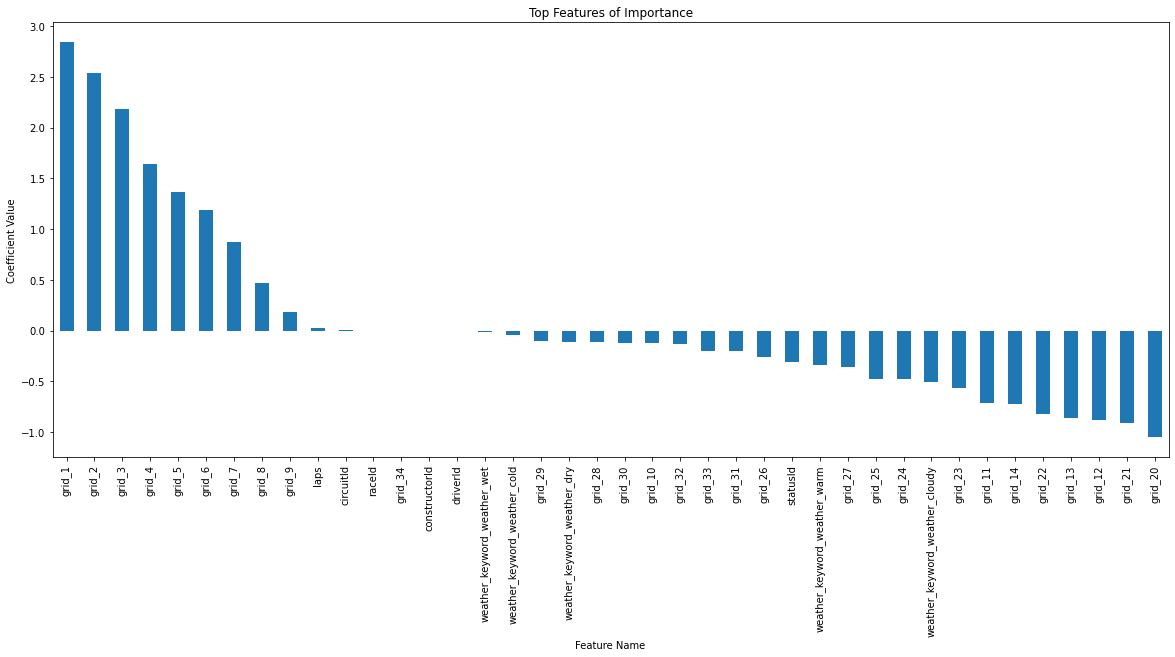

In [4]:
coefficients = logreg.coef_[0]
feature_importance = pd.Series(coefficients, index=features.columns).sort_values(ascending=False)

# Plot the top features of importance
plt.figure(figsize=(20, 8))
top_features = feature_importance.head(40)  # Get the top 10 features
top_features.plot(kind='bar')
plt.title('Top Features of Importance')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature Name')
plt.show()

In [ ]:
all_laps_data.head(5)

# Random Forest: Predicting Lap Time

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load Monaco race session
race = ff1.get_session(2023, "Monaco", '5')
race.load()  # This will load session specific data

# Extracting the lap data from the session
all_laps_data = race.laps

# dropping null values, outliers,
all_laps_data.dropna(subset=['LapTime'], inplace=True) 

# Convert time columns to seconds
all_laps_data['LapTime'] = all_laps_data['LapTime'].dt.total_seconds()

# Model to predict fastest lap
X = all_laps_data[['DriverNumber', 'LapNumber']]
y = all_laps_data['LapTime']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

# Using SimpleImputer after splitting the data to handle missing values with mean
imputer = SimpleImputer(strategy='mean')  
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Fitting the model
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

# Predicting
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.1.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '31', '44', '63', '16', '10', '55', '4', '81', '77', '21', '24', '23', '22', '11', '27', '2', '20', '18']


Mean Squared Error: 24.183114950421142


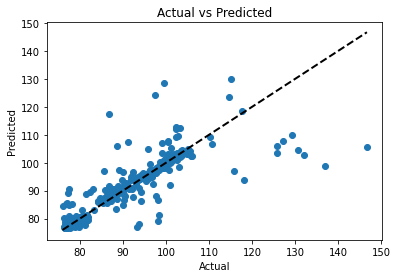

In [11]:
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()


In [12]:
all_laps_data['Sector1Time'] = all_laps_data['Sector1Time'].dt.total_seconds()
all_laps_data['Sector2Time'] = all_laps_data['Sector2Time'].dt.total_seconds()
all_laps_data['Sector3Time'] = all_laps_data['Sector3Time'].dt.total_seconds()
from sklearn.impute import SimpleImputer
# X = all_laps_data[['DriverNumber', 'LapNumber', 'Sector1Time', 'Sector2Time', 'Sector3Time']]
# y = all_laps_data['LapTime']